<a href="https://colab.research.google.com/github/helissonomc/ML-notebool/blob/main/vgg16_32input_droupout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# inicio

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!ls gdrive/My\ Drive

'Apresentação de analise.gslides'
 best_model_train_acc.h5
 best_model_train_loss.h5
 best_model_val_acc.h5
 best_model_val_loss.h5
'Cap. 4 - Grupo 1 - IA.pdf'
'Capitulo 3 - Agente de solução de problemas (1).pdf'
 Classroom
'Colab Notebooks'
'com.mojang.minecraftpe-1.13.1.5 (1).apk'
 com.mojang.minecraftpe-1.13.1.5.apk
 history.csv
 history.json
'How to get started with Drive.pdf'
 Inteligencia_Artificial_3a_Ed_Russell_St.gdoc
 Inteligencia_Artificial_3a_Ed_Russell_St.pdf
'Inteligencia Artificial Cap 3 Parte 2.pptx.pdf'
 last_epoch.h5
 modelo_89_5.h5
 modelo_89_cifar.h5
 Padroes_de_Projetos_-_Solucoes_Reutiliza.pdf
'Simulador PS - CAS MIPS - Trabalho em grupo (1).docx'
'Slide IA.pdf'
'Transformada Z parte Helisson.pptx'
'Untitled document (1).gdoc'
'Untitled document (2).gdoc'
'Untitled document (3).gdoc'
'Untitled document.gdoc'
'Untitled spreadsheet.gsheet'


# Imports

In [ ]:
import os
import json
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from numpy import expand_dims
from matplotlib import pyplot
from sklearn.metrics import accuracy_score
from keras.models import Model
from keras.layers import Dense
from keras.layers import Dropout
from keras.models import Sequential
from keras.layers import BatchNormalization

# Carregando dados do drive

In [ ]:
def unpickle(file, encoding='bytes'):
    with open(file, 'rb') as f:
        di = pickle.load(f, encoding=encoding)
    return di

In [ ]:
print(os.listdir("gdrive/My Drive/cifar-10-batches-py"))

['test_batch', 'data_batch_3', 'data_batch_2', 'data_batch_5', 'data_batch_1', 'data_batch_4', 'batches.meta', 'readme.html']


In [ ]:
batches_meta = unpickle(f"gdrive/My Drive/cifar-10-batches-py/batches.meta", encoding='utf-8')
label_names = batches_meta['label_names']

In [ ]:
batch_labels = []
batch_images = []

for n in range(1, 6):
    batch_dict = unpickle(f"gdrive/My Drive/cifar-10-batches-py/data_batch_{n}")
    # Add labels to the list of batch labels
    batch_labels.append(batch_dict[b'labels'])
    
    # Load the images, and resize them to 10000x3x32x32
    data = batch_dict[b'data'].reshape((10000,3,32,32))
    # Modify axis to be 10000x32x32x3, since this is the correct order for keras
    data = np.moveaxis(data, 1, -1)
    batch_images.append(data)

labels = np.concatenate(batch_labels, axis=0)
images = np.concatenate(batch_images, axis=0)

In [ ]:
test_dict = unpickle(f"gdrive/My Drive/cifar-10-batches-py/test_batch")
test_labels = np.array(test_dict[b'labels'])
test_images = test_dict[b'data'].reshape((10000,3,32,32))
test_images = np.moveaxis(test_images, 1, -1)

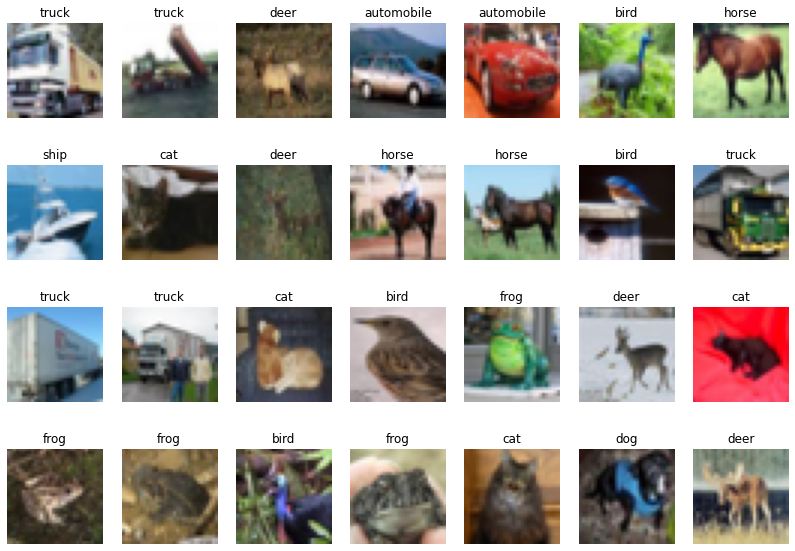

In [ ]:
fig = plt.figure(figsize=(14,10))

for n in range(1, 29):
    fig.add_subplot(4, 7, n)
    img = images[n]
    plt.imshow(img)
    plt.title(label_names[labels[n]])
    plt.axis('off')

In [ ]:

# We normalize the input according to the methods used in the paper
X_train = preprocess_input(images)
y_test = to_categorical(test_labels)

# We one-hot-encode the labels for training
X_test = preprocess_input(test_images)
y_train = to_categorical(labels)

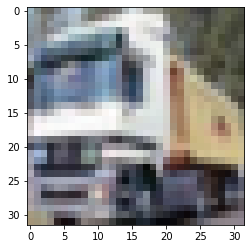

(50000, 32, 32, 3)

In [ ]:
pyplot.imshow(images[1])
pyplot.show()
images.shape

# Carregando dados do Keras

In [ ]:
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 5s 0us/step


In [ ]:
y_test2 = y_test

In [ ]:
mean_train = X_train.mean(axis=(0,1,2), keepdims=True)
std_train = X_train.std(axis=(0,1,2), keepdims=True)

In [ ]:
X_train = (X_train-mean_train)/std_train

In [ ]:
X_test = (X_test-mean_train)/std_train

In [ ]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Create Model

In [ ]:

def create_model():
  model = VGG16(
      weights=None, 
      include_top=True, 
      classes=10,
      input_shape=(32,32,3)
  )
  updated_model = Sequential()
  for layer in model.layers:
    updated_model.add(layer)
    if layer.name in ['block1_conv1']:
      updated_model.add(Dropout(0.3))
      updated_model.add(BatchNormalization())
    if layer.name in ['fc1', 'fc2']:
      updated_model.add(Dropout(0.1))
    if layer.name in ['block1_conv2','block2_conv2', 'block3_conv3', 'block4_conv3', 'block5_conv3']:
      updated_model.add(BatchNormalization())
    if layer.name in ['block2_conv1', 'block3_conv1', 'block3_conv2', 'block4_conv1', 'block4_conv2', 'block5_conv1', 'block5_conv2']:
      updated_model.add(Dropout(0.4))
      updated_model.add(BatchNormalization())
  model = updated_model
  model.compile(
    loss='categorical_crossentropy',
    optimizer='sgd',
    metrics=['accuracy']
  )
  return model

# Expand this cell for the model summary
create_model().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 64)        256       
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       7

In [ ]:
datagen = ImageDataGenerator(
			rotation_range=15,
			horizontal_flip=True,
      #validation_split=0.1,
			width_shift_range=0.1,
			height_shift_range=0.1)


In [ ]:
trainit = datagen.flow(X_train, y_train, batch_size=128)#, subset='training')
#validateit = datagen.flow(X_train, y_train, batch_size=128, subset='validation')

In [ ]:
best_train_acc = ModelCheckpoint(
    'gdrive/My Drive/best_model_train_acc.h5', 
    monitor='accuracy', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=False,
    mode='max'
)

best_val_acc = ModelCheckpoint(
    'gdrive/My Drive/best_model_val_acc.h5', 
    monitor='val_accuracy', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=False,
    mode='max'
)

best_val_loss = ModelCheckpoint(
    'gdrive/My Drive/best_model_val_loss.h5', 
    monitor='val_loss', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=False,
    mode='min'
)

best_train_loss = ModelCheckpoint(
    'gdrive/My Drive/best_model_train_loss.h5', 
    monitor='loss', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=False,
    mode='min'
)

model = create_model()
# Train the model
history = model.fit(trainit,
                    epochs=800,
                    callbacks=[best_train_acc, best_val_acc, best_val_loss, best_train_loss],
                    verbose=1,
                    validation_data=(X_test,y_test))
"""for e in range(30):
    print('Epoch', e)
    batches = 0
    for x_batch, y_batch in datagen.flow(X_train, y_train, batch_size=64):
        model.fit(x_batch, y_batch, validation_split=0.1)
        batches += 1
        if batches >= len(X_train) / 64:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break"""

Epoch 1/800
391/391 [==============================] - ETA: 0s - loss: 2.1351 - accuracy: 0.1718
Epoch 00001: accuracy improved from -inf to 0.17178, saving model to gdrive/My Drive/best_model_train_acc.h5

Epoch 00001: val_accuracy improved from -inf to 0.10450, saving model to gdrive/My Drive/best_model_val_acc.h5

Epoch 00001: val_loss improved from inf to 3.56423, saving model to gdrive/My Drive/best_model_val_loss.h5

Epoch 00001: loss improved from inf to 2.13514, saving model to gdrive/My Drive/best_model_train_loss.h5
391/391 [==============================] - 45s 114ms/step - loss: 2.1351 - accuracy: 0.1718 - val_loss: 3.5642 - val_accuracy: 0.1045
Epoch 2/800
391/391 [==============================] - ETA: 0s - loss: 1.8797 - accuracy: 0.2573
Epoch 00002: accuracy improved from 0.17178 to 0.25732, saving model to gdrive/My Drive/best_model_train_acc.h5

Epoch 00002: val_accuracy improved from 0.10450 to 0.10940, saving model to gdrive/My Drive/best_model_val_acc.h5

Epoch 000

# Predição

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validação'], loc='upper left')
plt.show()

NameError: ignored

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validação'], loc='upper left')
plt.show()

NameError: ignored

In [ ]:
import pandas as pd
hist_df = pd.DataFrame(history.history)
hist_json_file = 'gdrive/My Drive/history_testaval.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

In [ ]:
hist_csv_file = 'gdrive/My Drive/history_testaval.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
aux2 = np.array([])
for j in y_pred:
  aux2= np.append(aux2,np.argmax(j))

print(str(accuracy_score(y_test2, aux2)*100) + "%")

89.4%


In [ ]:
model.save("gdrive/My Drive/last_epoch.h5")